$\def \dot #1#2{\left\langle #1, #2 \right\rangle}$
$\def \adot #1#2{\left\langle #1, #2 \right\rangle}$
$\def \cD {\mathcal{D}}$
$\def \bc {\mathbf{c}}$
$\def \bv {\mathbf{v}}$
$\def \bG {\mathbf{G}}$

# Greedy algorithms with a 2d manifold

Here we consider the solutions of the PDE $u_h(a(y))$ where $y\in\mathbb{R}^2$, $a(y) = y_1 \chi_{D_1}(x) + y_2 \chi_{D_2}(x)$, and $D_1 = [0,1/2) \times [0,1]$ and $D_2 = [1/2, 1] \times [0,1]$, and $\chi_{D_1}$, $\chi_{D_2}$ are the indicator functions on $D_1$, $D_2$.

We're given our measurement space $W_m = \mathrm{span}\{w_1,\ldots,w_m\}$. We have a series of measurements $\langle w_i, u\rangle_V$, and we write $w := P_{W_m} u$, the projection of $u$ in $W_m$. We try random, even, and even sinusoidal measurements.

__Remarks:__
 - __Note that $\dot{\cdot}{\cdot} = \dot{\cdot}{\cdot}_{V_h}$ here.__
 - We can __assume that the $\omega_i$ are orthonormal__ as it is a fixed basis.
 - We store $\dot{\omega_i}{v}$ for each $v\in \cD$, so can we di all projections and inner-products in $\mathbb{R}^m$? And furthermore without the need of a Gram matrix $\dot{\phi_i}{\phi_j}$ to do the projection or orthonormalisation of $\phi_i$?
 - Finally, remember that _we can not know anything about $u$ other than $w :=P_{W_m} u$_, and we abuse notation slightly and also write $w=\dot{\omega_i}{u}$ for the vector in $\mathbb{R}^m$.

We have a dictionary $\cD$ of solutions $v(y)$, which we get from generating points in $y\in\mathbb{R}^{2}$ and then $v(y) = \frac{u_h(a(y))}{\| u_h(a(y)) \|_{V_h}}$ (i.e. we normalise all elements). 

__Algorithms 1-3, the "pure greedy", "measurement based OMP" and "measurement based PP" are used here.__

In [8]:
import numpy as np
import scipy as sp
import importlib
import seaborn as sns
import matplotlib.pyplot as plt
import pdb

import sys
sys.path.append("../../")
import pyApproxTools as pat
importlib.reload(pat)

%matplotlib inline

def make_2d_param_soln(points, fem_div, a_bar=1.0, c=0.5, f=1.0, verbose=False):
    
    solns = []
    fields = []

    for p in points:
        field = pat.PWConstantSqDyadicL2(a_bar + c * np.repeat(p[:,np.newaxis], 2, axis=1).T)
        fields.append(field)
        # Then the fem solver (there a faster way to do this all at once? This will be huge...
        fem_solver = pat.DyadicFEMSolver(div=fem_div, rand_field = field, f = 1)
        fem_solver.solve()
        solns.append(fem_solver.u)
        
    return solns, fields

### Generate the solution $u$ that we want to approximate

[0.8 0.1]


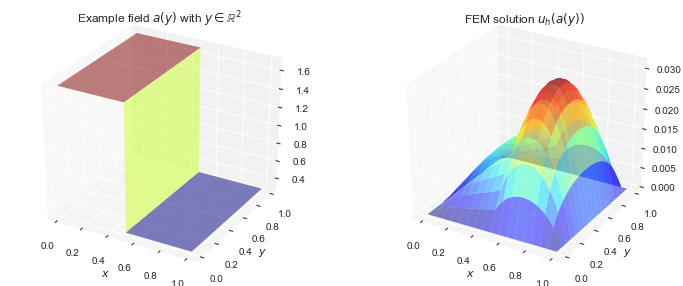

In [9]:
fem_div = 7

a_bar = 0.1
c = 2.0

np.random.seed(2)

y = np.array([[0.8, 0.1]])
print(y[0])
u, a = make_2d_param_soln(y, fem_div, a_bar=a_bar, c=c)
u = u[0]
a = a[0]

fig = plt.figure(figsize=(12, 5))
ax = fig.add_subplot(1, 2, 1, projection='3d')
a.plot(ax, title='Example field $a(y)$ with $y\in\mathbb{R}^2$')
ax = fig.add_subplot(1, 2, 2, projection='3d')
u.plot(ax, title='FEM solution $u_h(a(y))$')
plt.show()

### Generate the basis $W_m$ of randomly placed local averages

m = 64


[]

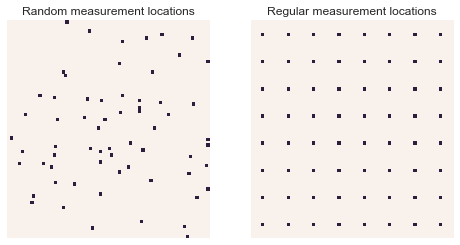

In [15]:
# local_width is the width of the measurement squares in terms of FEM mesh squares
width_div = 1
local_width = 2**width_div
spacing_div = 4

Wm_reg, Wloc_reg = pat.make_local_avg_grid_basis(width_div, spacing_div, fem_div, return_map=True)
Wm_reg = Wm_reg.orthonormalise()

m = Wm_reg.n
print('m =', m)

# We make the ambient spaces for Wm and Vn
np.random.seed(2)

Wm_rand, Wloc_rand = pat.make_pw_local_avg_random_basis(m=m, div=fem_div, width=local_width, return_map=True)
Wm_rand = Wm_rand.orthonormalise()

fig = plt.figure(figsize=(8, 4))
ax = fig.add_subplot(1, 2, 1)
sns.heatmap(Wloc_rand.values, xticklabels=False, yticklabels=False, cbar=False, ax=ax)
ax.set_title('Random measurement locations')
ax = fig.add_subplot(1, 2, 2)
sns.heatmap(Wloc_reg.values, xticklabels=False, yticklabels=False, cbar=False, ax=ax)
ax.set_title('Regular measurement locations')
plt.plot()

### Generate the dictionary of snapshots

Note that the $y$ that form the dictionary are on the regular ```dict_n``` $\times$ ```dict_N``` grid in $[0,1]^2$.

In [16]:
dict_N = 20
dict_grid = np.linspace(0.0, 1.0, dict_N, endpoint=False)
y1s, y2s = np.meshgrid(dict_grid, dict_grid)

y1s = y1s.flatten()
y2s = y2s.flatten()

dict_ys = np.stack([y1s, y2s]).T

dictionary, dictionary_fields = make_2d_param_soln(dict_ys, fem_div, a_bar=a_bar, c=c)

In [17]:
greedy_algs = [pat.GreedyApprox(dictionary, Vn=pat.PWBasis(), verbose=True),
pat.MeasBasedOMP(dictionary, u, Wm_reg, Vn=pat.PWBasis(), verbose=True),
pat.MeasBasedPP(dictionary, u, Wm_reg, Vn=pat.PWBasis(), verbose=True),
pat.MeasBasedOMP(dictionary, u, Wm_rand, Vn=pat.PWBasis(), verbose=True),
pat.MeasBasedPP(dictionary, u, Wm_rand, Vn=pat.PWBasis(), verbose=True)]

greedy_algs_labels = ['Plain greedy', 
                      'Reg grid meas based OMP', 'Reg grid meas based PP', 
                      'Rand meas based OMP', 'Rand meas based PP',]

for g, l in zip(greedy_algs, greedy_algs_labels):
    print('Constructing ' + l)
    g.construct_to_n(m)

Constructing Plain greedy
i 	 Selection 	 Sel. criteria
1 : 	 0 	 0.46862352375087635
2 : 	 19 		 0.1730084172562857
3 : 	 380 		 0.16231579580949737
Vn spans all dictionary points at n=3, stopping greedy
Done!
Constructing Reg grid meas based OMP
i 	 Selection 	 Sel. criteria
1 : 	 56 	 0.07283405665391665
Vn spans all dictionary points at n=1, stopping greedy
Done!
Constructing Reg grid meas based PP
i 	 Selection 	 Sel. criteria
1 : 	 56 	 0.07283405665391665
Vn spans all dictionary points at n=1, stopping greedy
Done!
Constructing Rand meas based OMP
i 	 Selection 	 Sel. criteria
1 : 	 56 	 0.07043352905187653
Vn spans all dictionary points at n=1, stopping greedy
Done!
Constructing Rand meas based PP
i 	 Selection 	 Sel. criteria
1 : 	 56 	 0.07043352905187653
Vn spans all dictionary points at n=1, stopping greedy
Done!


### So we see that all greedy algorithms select the same 3 points, that span all the dictionary points, and certainly also spans all of $\mathcal{M}$

In [18]:
for i, greedy in enumerate(greedy_algs):
    ps = dict_ys[np.array(greedy.dict_sel, dtype=np.int32), :]
    print(greedy_algs_labels[i])
    print(ps)

Plain greedy
[[0.   0.  ]
 [0.95 0.  ]
 [0.   0.95]]
Reg grid meas based OMP
[[0.8 0.1]]
Reg grid meas based PP
[[0.8 0.1]]
Rand meas based OMP
[[0.8 0.1]]
Rand meas based PP
[[0.8 0.1]]


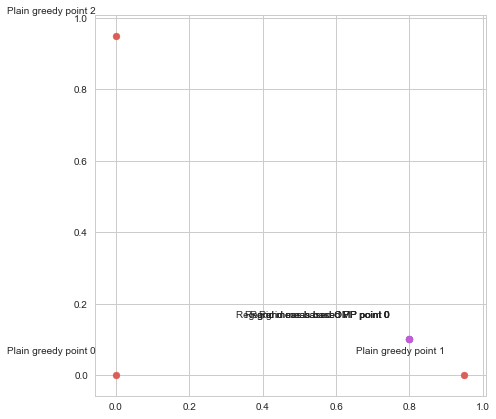

In [22]:
sns.set_palette('hls', len(greedy_algs))
sns.set_style('whitegrid')

fig = plt.figure(figsize=(7,7))

for i, greedy in enumerate(greedy_algs):
    labels = ['{0} point {1}'.format(greedy_algs_labels[i], j) for j in range(greedy.n)] 
    
    ps = dict_ys[np.array(greedy.dict_sel, dtype=np.int32), :]
    
    plt.scatter(ps[:, 0], ps[:, 1], marker='o')

    for label, x, y in zip(labels, ps[:, 0], ps[:, 1]):
        plt.annotate(
            label, xy=(x, y), xytext=(-20, 20), textcoords='offset points', ha='right', va='bottom')

plt.show()

### Wait so we really have 3 linearly independent solutions and that's it?

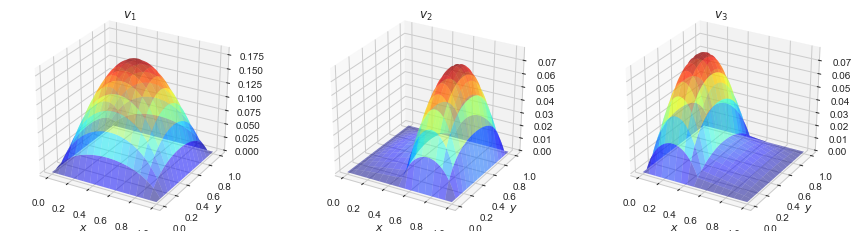

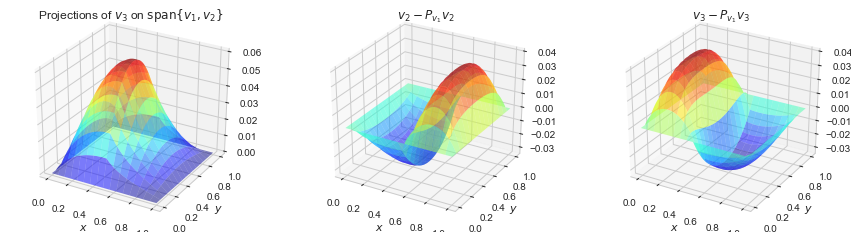

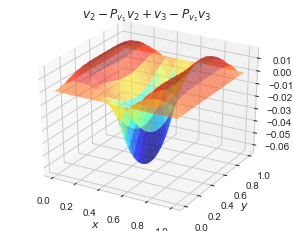

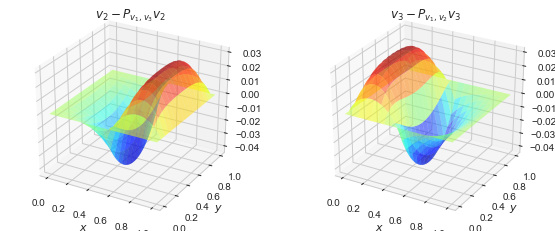

max(v2_perp + v3_perp):  0.0677108945675
dot: -0.0103338686972


In [84]:
Vn = g.Vn

fig = plt.figure(figsize=(15, 4))
for i,v in enumerate(Vn.vecs):
    ax = fig.add_subplot(1, 3, i+1, projection='3d')
    v.plot(ax, title=r'$v_{{{0}}}$'.format(i+1))
plt.show()

v3_p = Vn.subspace(slice(0,2)).project(Vn.vecs[-1])
v2_perp = Vn.vecs[1] - Vn.subspace(slice(0,1)).project(Vn.vecs[1])
v3_perp = Vn.vecs[2] - Vn.subspace(slice(0,1)).project(Vn.vecs[2])

v2_orth = Vn.vecs[1] - Vn.subspace_mask(np.array([1,0,1],dtype=np.bool)).project(Vn.vecs[1])
v3_orth = Vn.vecs[2] - Vn.subspace(slice(0,2)).project(Vn.vecs[2])


fig = plt.figure(figsize=(15, 4))
ax = fig.add_subplot(1, 3, 1, projection='3d')
v3_p.plot(ax, title=r'Projections of $v_3$ on $\mathrm{span}\{v_1,v_2\}$')
ax = fig.add_subplot(1, 3, 2, projection='3d')
v2_perp.plot(ax, title=r'$v_2 - P_{v_1} v_2$')
ax = fig.add_subplot(1, 3, 3, projection='3d')
v3_perp.plot(ax, title=r'$v_3 - P_{v_1} v_3$')
plt.show()

fig = plt.figure(figsize=(5, 4))
ax = fig.add_subplot(1, 1, 1, projection='3d')
(v2_perp + v3_perp).plot(ax, title=r'$v_2 - P_{v_1} v_2 + v_3 - P_{v_1} v_3$')
plt.show()

fig = plt.figure(figsize=(15, 4))
ax = fig.add_subplot(1, 3, 1, projection='3d')
v2_orth.plot(ax, title=r'$v_2 - P_{v_1,v_3} v_2$')
ax = fig.add_subplot(1, 3, 2, projection='3d')
v3_orth.plot(ax, title=r'$v_3 - P_{v_1,v_2} v_3$')
plt.show()

print('max(v2_perp + v3_perp): ', (v2_perp - v3_perp).values.max())
print('dot:', v2_perp.dot(v3_perp))



### Can we find a closed form for the coefficients of this 2d solution, when expressed as a sum of the sub-domain solutions?

[ 1.         -0.36109849]
[ 1.          2.00719269]
y= [[ 0.91241841  0.12314124]]
ym= 1.135559651
yd= 0.789277169
yd/ym= 0.695055665552
-1.0000000002
1.0000000002
zd / ym(1+zd) = 0.361098488106
zd / ym(1-zd) = 2.00719268713


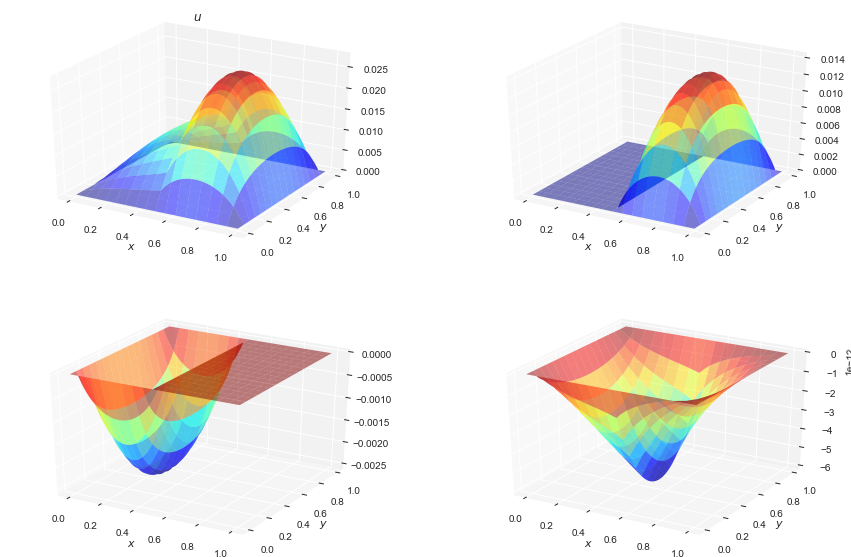

In [59]:
np.random.seed(2)

y = np.array([[0.91241841, 0.123141241]])

y1 = np.array([[y[0,0], 1e10]])
y2 = np.array([[1e10, y[0,1]]])
y1 = np.array([[1, 1e10]])
y2 = np.array([[1e10, 1]])

yw = np.array([[y.mean(),y.mean()]])

u, a = make_2d_param_soln(y, fem_div, a_bar=a_bar, c=c)
uw, aw = make_2d_param_soln(yw, fem_div, a_bar=a_bar, c=c)
u0, a0 = make_2d_param_soln(np.array([[1,1]]), fem_div, a_bar=0, c=1)
u1, a1 = make_2d_param_soln(y1, fem_div, a_bar=0, c=1)
u2, a2 = make_2d_param_soln(y2, fem_div, a_bar=0, c=1)

u = u[0]
u0 = u0[0]
uw = uw[0]
u1=u1[0]
u2=u2[0]

M = np.array([[uw.values[12,55], uw.values[61, 23]], [u1.values[12,55], u1.values[61, 23]]])
w = np.array([u.values[12,55], u.values[61, 23]])

wp2 = np.linalg.solve(M.T, w)
print(wp2)
u_proc_2 = u - wp2[0]*uw - wp2[1]*u1

M = np.array([[uw.values[12,68], uw.values[61, 100]], [u2.values[12,68], u2.values[61, 100]]])
w = np.array([u.values[12,68], u.values[61, 100]])
wp1 = np.linalg.solve(M.T, w)
print(wp1)
u_proc_1 = u - wp1[0]*uw - wp1[1]*u2

ym = a_bar + y.mean() * c
yd = c *0.5 * (y[0,0] - y[0,1])
print('y=', y)
print('ym=', ym)
print('yd=', yd)
print('yd/ym=', yd/ym)
print((ym/yd) * wp2[1] * (a_bar + c*y[0,0]))
print((ym/yd) * wp1[1] * (a_bar + c*y[0,1]))

zd = yd/ym
print('zd / ym(1+zd) =', zd / (ym*(1+zd)))
print('zd / ym(1-zd) =', zd / (ym*(1-zd)))

fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot(2, 2, 1, projection='3d')
u.plot(ax, title='$u$')
ax = fig.add_subplot(2, 2, 2, projection='3d')
u_proc_2.plot(ax, title='')
ax = fig.add_subplot(2, 2, 3, projection='3d')
u_proc_1.plot(ax, title='')
ax = fig.add_subplot(2, 2, 4, projection='3d')
#(u - uw - (yd/ym) * (u2 - u1)).plot(ax, title='')
(u - uw - (yd/ym) * (u2/(a_bar + c*y[0,1]) - u1/(a_bar + c*y[0,0]))).plot(ax, title='')
plt.show()


### Lets try applying those operators $A_0$, $A_1$ and $A_2$ and see what properties we observe

y = [[ 0.91241841  0.12314124]]
(16129,)
(16129, 16129)


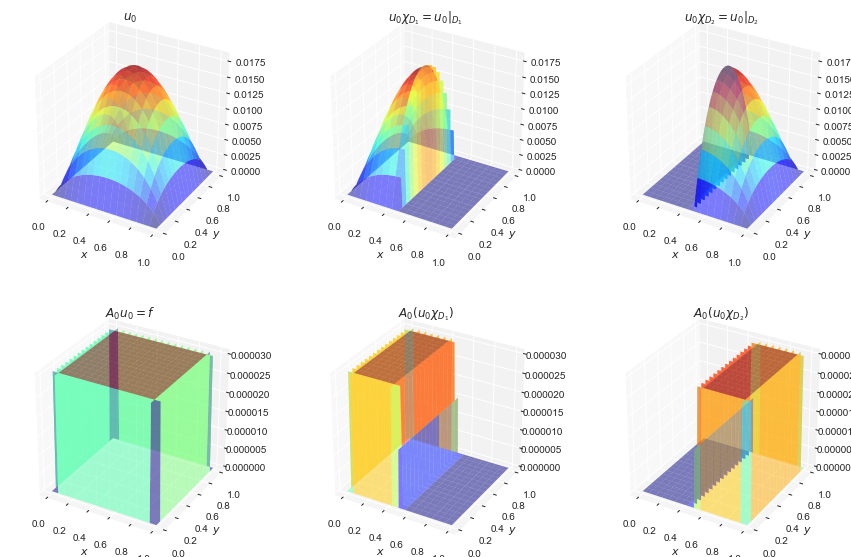

In [60]:
print('y =', y)

u, a = make_2d_param_soln(y, fem_div, a_bar=a_bar, c=c)
u0, a0 = make_2d_param_soln(np.array([[1,1]]), fem_div, a_bar=0, c=1)
u1, a1 = make_2d_param_soln(y1, fem_div, a_bar=0, c=1)
u2, a2 = make_2d_param_soln(y2, fem_div, a_bar=0, c=1)
u = u[0]
a = a[0]
u0=u0[0]
a0=a0[0]
u1=u1[0]
u2=u2[0]

fem_solver = pat.DyadicFEMSolver(div=fem_div, rand_field=a0, f=1)

import scipy.linalg
import scipy.sparse

n_side = 2**fem_div - 1
h = 1.0 / (n_side + 1)

a = np.copy(a0.interpolate(fem_div).values)
a[:,2**(fem_div-1):] = 0
diag = 2.0 * (a[:-1, :-1] + a[:-1,1:] + a[1:,:-1] + a[1:, 1:]).flatten()
lr_diag = -(a[1:, 1:] + a[:-1, 1:]).flatten()
lr_diag[n_side-1::n_side] = 0 # These corresponds to edges on left or right extreme
lr_diag = lr_diag[:-1]
ud_diag = -(a[1:-1, 1:] + a[1:-1, :-1]).flatten()
A0_1 = scipy.sparse.diags([diag, lr_diag, lr_diag, ud_diag, ud_diag], [0, -1, 1, -n_side, n_side]).tocsr()

a = np.copy(a0.interpolate(fem_div).values)
a[:,:2**(fem_div-1)] = 0
diag = 2.0 * (a[:-1, :-1] + a[:-1,1:] + a[1:,:-1] + a[1:, 1:]).flatten()
lr_diag = -(a[1:, 1:] + a[:-1, 1:]).flatten()
lr_diag[n_side-1::n_side] = 0 # These corresponds to edges on left or right extreme
lr_diag = lr_diag[:-1]
ud_diag = -(a[1:-1, 1:] + a[1:-1, :-1]).flatten()
A0_2 = scipy.sparse.diags([diag, lr_diag, lr_diag, ud_diag, ud_diag], [0, -1, 1, -n_side, n_side]).tocsr()

u0_1 = pat.PWLinearSqDyadicH1(u0.values)
u0_1.values[:, 2**(fem_div-1):] = 0

u0_2 = pat.PWLinearSqDyadicH1(u0.values)
u0_2.values[:, :2**(fem_div-1)] = 0

print(u0.values[1:-1,1:-1].flatten().shape)
print(A0_1.shape)

f = fem_solver.A @ u0.values[1:-1,1:-1].flatten()
f0_1 = A0_1 @ u0.values[1:-1,1:-1].flatten()
f0_2 = A0_2 @ u0.values[1:-1,1:-1].flatten()

n_side = 2**fem_div - 1
f = f.reshape([n_side, n_side])
f0_1 = f0_1.reshape([n_side, n_side])
f0_2 = f0_2.reshape([n_side, n_side])

ff = pat.PWLinearSqDyadicH1(np.pad(f, ((1,1),(1,1)), 'constant'))
f0_1f = pat.PWLinearSqDyadicH1(np.pad(f0_1, ((1,1),(1,1)), 'constant'))
f0_2f = pat.PWLinearSqDyadicH1(np.pad(f0_2, ((1,1),(1,1)), 'constant'))

fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot(2, 3, 1, projection='3d')
u0.plot(ax, title=r'$u_0$')
ax = fig.add_subplot(2, 3, 2, projection='3d')
u0_1.plot(ax, title=r'$u_0 \chi_{D_1} = u_0 |_{D_1}$')
ax = fig.add_subplot(2, 3, 3, projection='3d')
u0_2.plot(ax, title=r'$u_0 \chi_{D_2} = u_0 |_{D_2}$')
ax = fig.add_subplot(2, 3, 4, projection='3d')
ff.plot(ax, title=r'$A_0 u_0 = f$')
ax = fig.add_subplot(2, 3, 5, projection='3d')
f0_1f.plot(ax, title=r'$A_0 (u_0 \chi_{D_1})$')
ax = fig.add_subplot(2, 3, 6, projection='3d')
f0_2f.plot(ax, title=r'$A_0 (u_0 \chi_{D_2})$')
plt.show()

So we clearly see that $A_0 (\chi_{D_i} u_0) \neq \chi_{D_i} f$, which makes sense. On the other hand I suspect we still have that in the weak sense $A_0 (\chi_{D_i} u_0) = A_i u_i$

In [61]:
print((f0_1f + f0_2f).values.sum())
print(ff.values.sum())

0.492218017578
0.492218017578


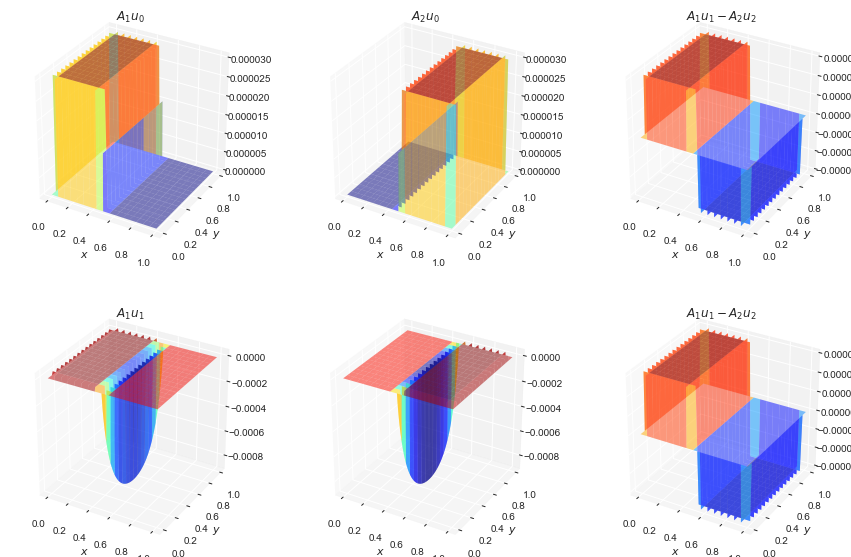

0.246109008789
0.154920031099
0.246109008789
0.1549200311


In [73]:
n_side = 2**fem_div - 1

# Make u's
u, a = make_2d_param_soln(y, fem_div, a_bar=a_bar, c=c)
u0, a0 = make_2d_param_soln(np.array([[1,1]]), fem_div, a_bar=0, c=1)
u1, a1 = make_2d_param_soln(y1, fem_div, a_bar=0, c=1)
u2, a2 = make_2d_param_soln(y2, fem_div, a_bar=0, c=1)
u = u[0]
u0=u0[0]
u1=u1[0]
u2=u2[0]

# Lets make A_0, A_1 and A_2
fem_solver = pat.DyadicFEMSolver(div=fem_div, rand_field = pat.PWConstantSqDyadicL2(np.ones((2,2))), f = 1)
A0 = fem_solver.A

vals = np.array([[1.0, 0.0]])
a1 = pat.PWConstantSqDyadicL2(np.repeat(vals, 2, axis=1).reshape((2,2)).T)
fem_solver = pat.DyadicFEMSolver(div=fem_div, rand_field = a1, f = 1)
A1 = fem_solver.A

vals = np.array([[0.0, 1.0]])
a2 = pat.PWConstantSqDyadicL2(np.repeat(vals, 2, axis=1).reshape((2,2)).T)
fem_solver = pat.DyadicFEMSolver(div=fem_div, rand_field = a2, f = 1)
A2 = fem_solver.A

def apply_operator(A, u):
    return pat.PWLinearSqDyadicH1(np.pad((A @ u.values[1:-1,1:-1].flatten()).reshape([n_side, n_side]), ((1,1),(1,1)), 'constant'))

f0 = apply_operator(A0, u0)
f1 = apply_operator(A1, u0)
f2 = apply_operator(A2, u0)

fig = plt.figure(figsize=(15, 10))
#ax = fig.add_subplot(2, 3, 1, projection='3d')
#f0.plot(ax, title=r'$A_0 u_0$')
ax = fig.add_subplot(2, 3, 1, projection='3d')
f1.plot(ax, title=r'$A_1 u_0$')
ax = fig.add_subplot(2, 3, 2, projection='3d')
f2.plot(ax, title=r'$A_2 u_0$')
ax = fig.add_subplot(2, 3, 3, projection='3d')
(f1-f2).plot(ax, title=r'$A_1u_0 - A_2u_0$')
ax = fig.add_subplot(2, 3, 4, projection='3d')
apply_operator(A1, u1).plot(ax, title=r'$A_1 u_1$')
ax = fig.add_subplot(2, 3, 5, projection='3d')
apply_operator(A2, u2).plot(ax, title='')
ax = fig.add_subplot(2, 3, 6, projection='3d')
(apply_operator(A1, u1) - apply_operator(A2, u2)).plot(ax, title=r'$A_1u_1 - A_2u_2$')
plt.show()

print(apply_operator(A2, u0).values.sum())
print(apply_operator(A2, u2).values.sum())
print(apply_operator(A1, u0).values.sum())
print(apply_operator(A1, u1).values.sum())

### Lets move the boundary from the center as symmetry may be reducing the dimensionality

In [36]:
def make_sliver_soln(points, fem_div, a_bar=1.0, c=0.5, f=1.0, verbose=False):
    
    solns = []
    fields = []

    for p in points:
        vals = p[0] * np.ones((4,4))
        vals[:,:3] = p[1]
        field = pat.PWConstantSqDyadicL2(a_bar + c * vals)
        fields.append(field)
        # Then the fem solver (there a faster way to do this all at once? This will be huge...
        fem_solver = pat.DyadicFEMSolver(div=fem_div, rand_field = field, f = 1)
        fem_solver.solve()
        solns.append(fem_solver.u)
        
    return solns, fields

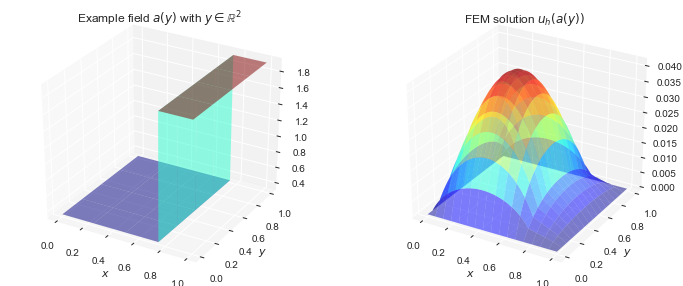

In [38]:
fem_div = 7

a_bar = 0.1
c = 2.0

y = np.array([[0.91241841, 0.123141241]])

u, a = make_sliver_soln(y, fem_div, a_bar=a_bar, c=c)
u = u[0]
a = a[0]

fig = plt.figure(figsize=(12, 5))
ax = fig.add_subplot(1, 2, 1, projection='3d')
a.plot(ax, title='Example field $a(y)$ with $y\in\mathbb{R}^2$')
ax = fig.add_subplot(1, 2, 2, projection='3d')
u.plot(ax, title='FEM solution $u_h(a(y))$')
plt.show()

y= [[ 0.91241841  0.12314124]]
ym= 1.135559651
yd= 0.789277169
yd/ym= 0.695055665552
-1.0000000002
1.0000000002
zd / ym(1+zd) = 0.361098488106
zd / ym(1-zd) = 2.00719268713
Calculated coefficients: [ 0.77338661 -0.24916244  2.11455735]


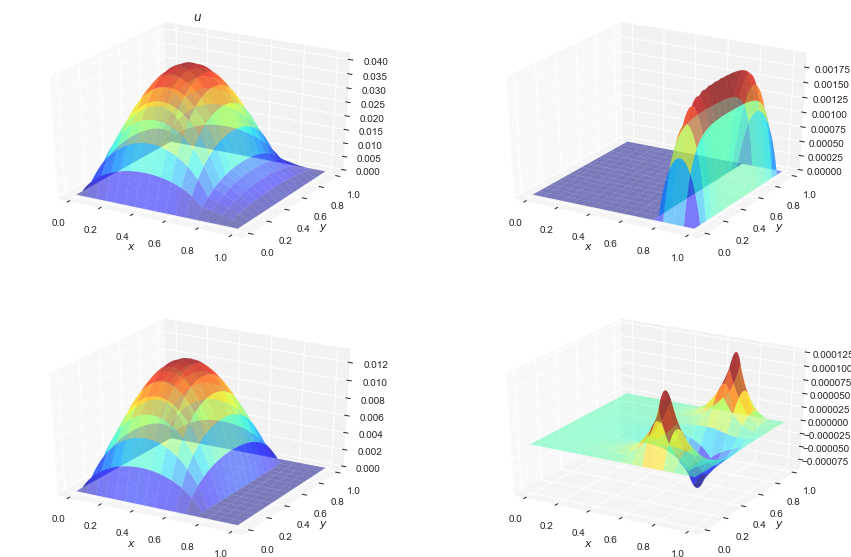

In [74]:
y1 = np.array([[1, 1e10]])
y2 = np.array([[1e10, 1]])

yw = np.array([[y.mean(),y.mean()]])

u, a = make_sliver_soln(y, fem_div, a_bar=a_bar, c=c)
uw, aw = make_sliver_soln(yw, fem_div, a_bar=a_bar, c=c)
u0, a0 = make_sliver_soln(np.array([[1,1]]), fem_div, a_bar=0, c=1)
u1, a1 = make_sliver_soln(y1, fem_div, a_bar=0, c=1)
u2, a2 = make_sliver_soln(y2, fem_div, a_bar=0, c=1)

u = u[0]
u0=u0[0]
uw=uw[0]
u1=u1[0]
u2=u2[0]

ym = a_bar + y.mean() * c
yd = c *0.5 * (y[0,0] - y[0,1])
print('y=', y)
print('ym=', ym)
print('yd=', yd)
print('yd/ym=', yd/ym)
print((ym/yd) * wp2[1] * (a_bar + c*y[0,0]))
print((ym/yd) * wp1[1] * (a_bar + c*y[0,1]))

zd = yd/ym
print('zd / ym(1+zd) =', zd / (ym*(1+zd)))
print('zd / ym(1-zd) =', zd / (ym*(1-zd)))

us = [u0, u1, u2]
M = np.vstack([v.values.flatten() for v in us])
w = u.values.flatten()

C = M @ M.T
g = M @ w

cf = np.linalg.solve(C, g)
print("Calculated coefficients:", cf)

fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot(2, 2, 1, projection='3d')
u.plot(ax, title='$u$')
ax = fig.add_subplot(2, 2, 2, projection='3d')
u1.plot(ax, title='')
ax = fig.add_subplot(2, 2, 3, projection='3d')
u2.plot(ax, title='')
ax = fig.add_subplot(2, 2, 4, projection='3d')
#(u - uw - (yd/ym) * (u2/(a_bar + c*y[0,1]) - u1/(a_bar + c*y[0,0]))).plot(ax, title='')
(u - cf[0] * u0 - cf[1] * u1 - cf[2] * u2).plot(ax, title='')
plt.show()

We rewrite the field as
$$
a(y) = \bar{a} + c (y_1\chi_{D_1} + y_2\chi_{D_2}) 
= y_m \left(1+ y_d\left(\chi_{D_1} - \chi_{D_2} \right)\right)
$$
where $y_m = \bar{a} + c\frac{y_1+y_2}{2}$ and $y_d = \frac{\frac{y_1-y_2}{2}}{y_m}$. We then define the operators $A_0$, $A_1$ and $A_2$ as in my notes.

The equation previously written as $(\bar{a}A_0 + cy_1A_1 + cy_2A_2)u$ now becomes
$$
y_m \left(A_0 u + y_d\left(A_1 u - A_2 u \right)\right)
$$

What does this get us? We try on full $u$ and the domain decomposed $u$'s, i.e. solutions to $A_i$ on $H_0^1(D_i)$

### First for the sliver... and we clearly see that $A_1 u_0 \neq A_1 u_1$, proving the point that this is exactly where symmetry is needed in my argument

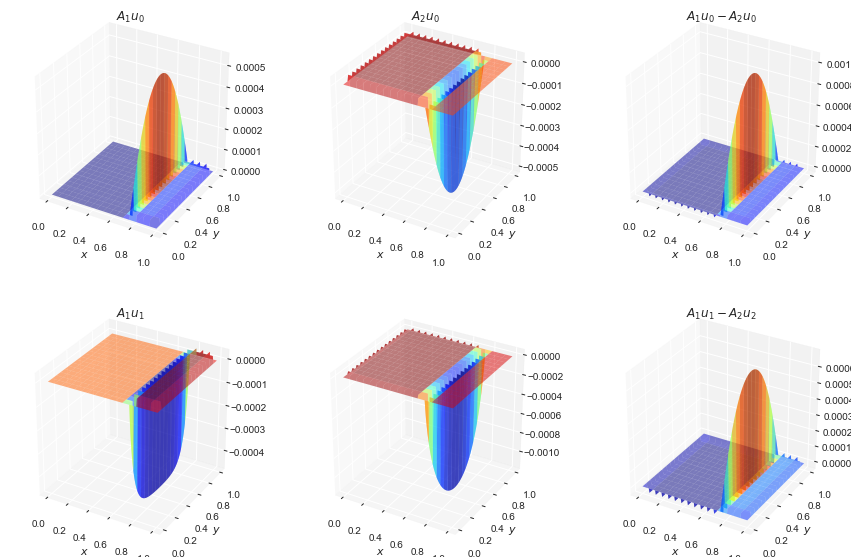

0.324998930052
0.256797737454
0.167219087526
0.0680752999858


In [77]:
n_side = 2**fem_div - 1

# Lets make A_0, A_1 and A_2
fem_solver = pat.DyadicFEMSolver(div=fem_div, rand_field = pat.PWConstantSqDyadicL2(np.ones((2,2))), f = 1)
A0 = fem_solver.A

vals = np.ones((4,4))
vals[:,:3] = 0.0
a1 = pat.PWConstantSqDyadicL2(vals)
fem_solver = pat.DyadicFEMSolver(div=fem_div, rand_field = a1, f = 1)
A1 = fem_solver.A

vals = np.zeros((4,4))
vals[:,:3] = 1.0
a2 = pat.PWConstantSqDyadicL2(vals)
fem_solver = pat.DyadicFEMSolver(div=fem_div, rand_field = a2, f = 1)
A2 = fem_solver.A

def apply_operator(A, u):
    return pat.PWLinearSqDyadicH1(np.pad((A @ u.values[1:-1,1:-1].flatten()).reshape([n_side, n_side]), ((1,1),(1,1)), 'constant'))

f0 = apply_operator(A0, u0)
f1 = apply_operator(A1, u0)
f2 = apply_operator(A2, u0)

fig = plt.figure(figsize=(15, 10))
#ax = fig.add_subplot(2, 3, 1, projection='3d')
#f0.plot(ax, title=r'$A_0 u_0$')
ax = fig.add_subplot(2, 3, 1, projection='3d')
f1.plot(ax, title=r'$A_1 u_0$')
ax = fig.add_subplot(2, 3, 2, projection='3d')
f2.plot(ax, title=r'$A_2 u_0$')
ax = fig.add_subplot(2, 3, 3, projection='3d')
(f1-f2).plot(ax, title=r'$A_1u_0 - A_2u_0$')
ax = fig.add_subplot(2, 3, 4, projection='3d')
apply_operator(A1, u1).plot(ax, title=r'$A_1 u_1$')
ax = fig.add_subplot(2, 3, 5, projection='3d')
apply_operator(A2, u2).plot(ax, title='')
ax = fig.add_subplot(2, 3, 6, projection='3d')
((apply_operator(A1, u1) - apply_operator(A2, u2))).plot(ax, title=r'$A_1u_1 - A_2u_2$')
plt.show()

print(apply_operator(A2, u0).values.sum())
print(apply_operator(A2, u2).values.sum())
print(apply_operator(A1, u0).values.sum())
print(apply_operator(A1, u1).values.sum())